In [1]:
import sys

sys.path.append('/home/jp/anaconda3/envs/test_env/lib/python3.8/site-packages')

import os
import glob

#For Images
import cv2
import matplotlib.pyplot as plt
import numpy as np

#For checking progress
from tqdm import tqdm_notebook

import datetime

#PyTorch Packages
import torch
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

os.getcwd()

'/home/jp/Desktop/archive/dataset'

In [2]:

#Funcao que converte as imagens e faz a transformacao caso tenha.

def get_image(path,transform=False):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if transform:
        img = transform(img)
    return img

#Mostra os dados de treino como default p/ analise rapida.
def show_data(rows,cols,is_train=True,transform=False):
    if is_train:
        path = '/home/jp/Desktop/archive/dataset/dataset/train/'
    else:
        path = '/home/jp/Desktop/archive/dataset/dataset/test/'
    path = os.path.join(path,'*orange*','*.png')
    img_paths = glob.glob(path)
    np.random.seed(0)
    img_paths = np.random.choice(img_paths,rows*cols)
    fig = plt.figure(figsize=(8,8),dpi=150)
    i = 1
    for r in range(rows):
        for c in range(cols):
            image_path = img_paths[i-1]
            if 'fresh' in image_path.split('/')[-2]:
                title = 'Fresh'
            else:
                title = 'Rotten'
            ax = fig.add_subplot(rows,cols,i)
            img = get_image(image_path,transform)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(title,fontsize=5)
            ax.imshow(img)
            i+=1
    return fig

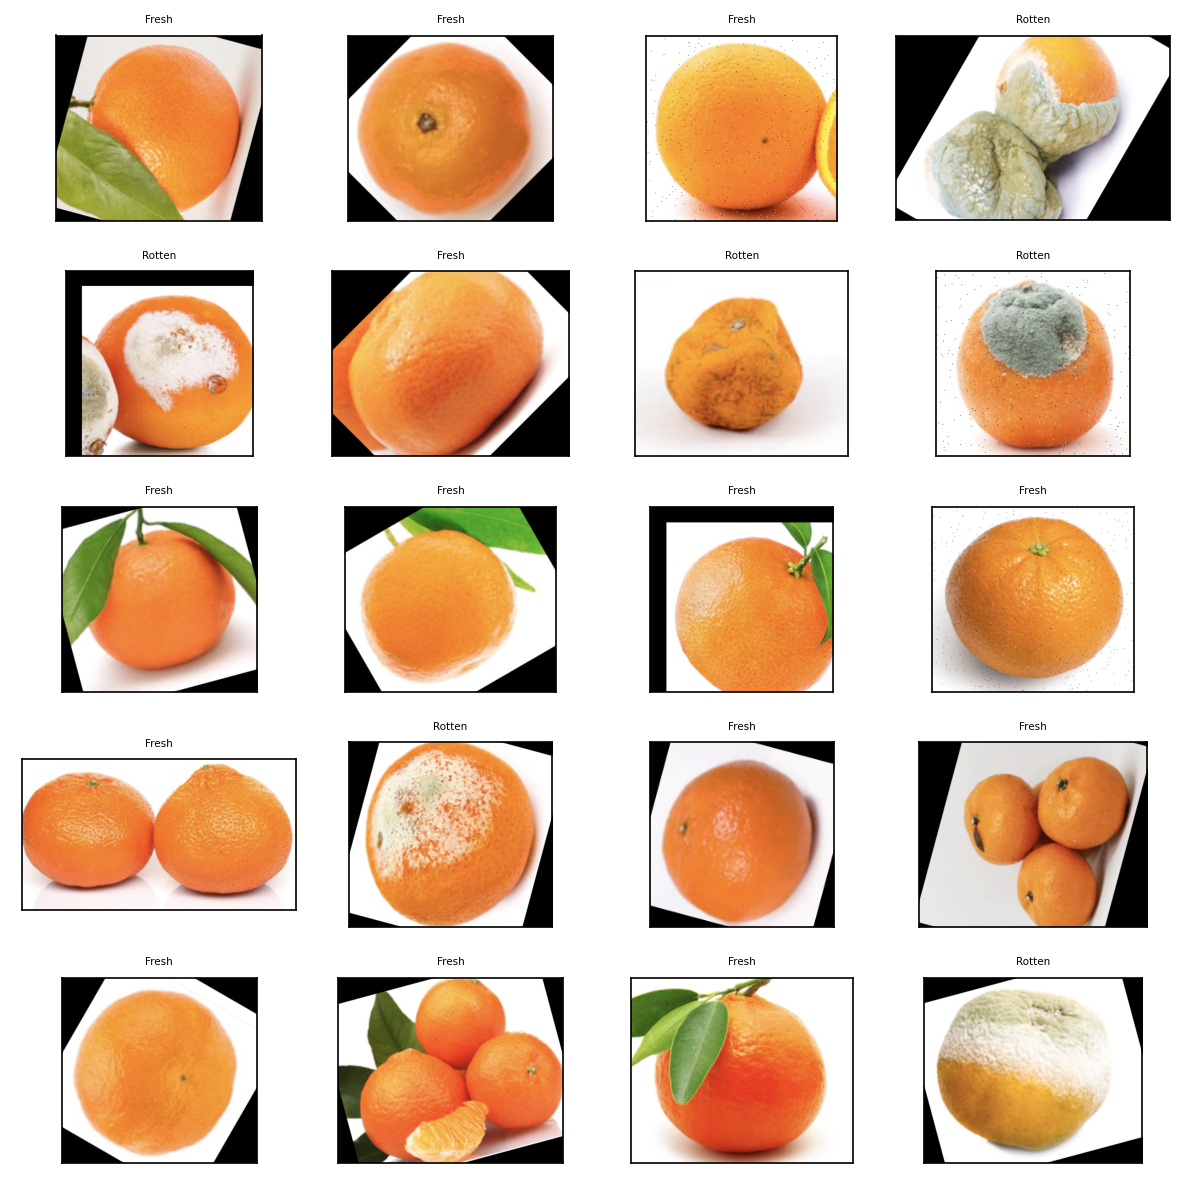

In [4]:
fig = show_data(5,4, True)
fig.tight_layout()

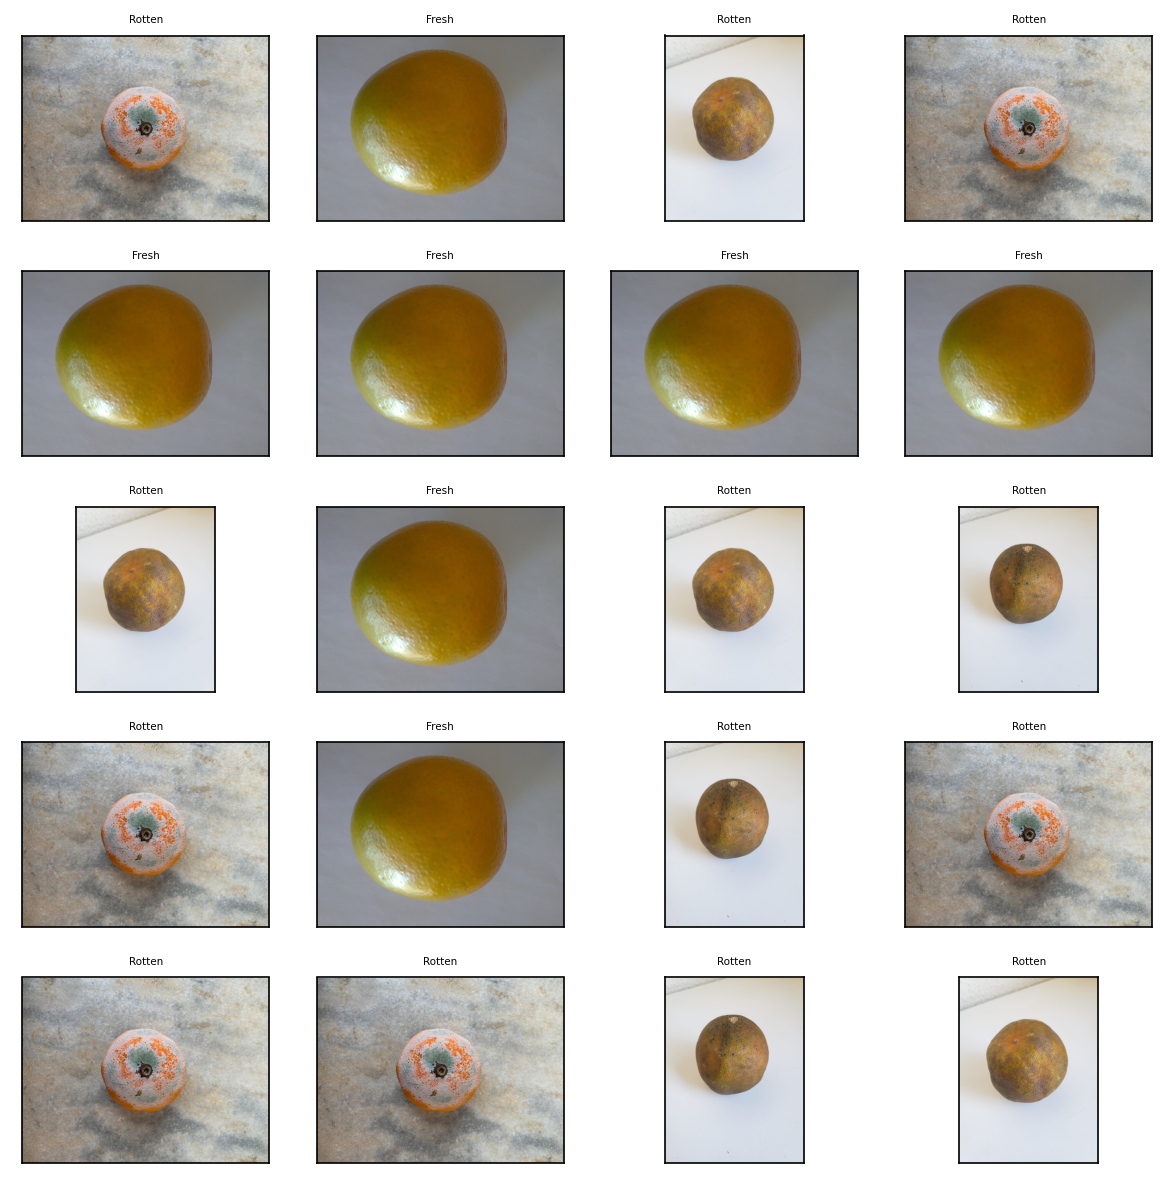

In [5]:
fig = show_data(5,4,is_train=False)
fig.tight_layout()

In [6]:
from PIL import Image



class FruitsDataset(Dataset):
    def __init__(self,path,classifier_type='Rotten',subset='train',transforms=None):
        self.subset = subset
        if self.subset == 'train':
            self.PATH = os.path.join(path,'train','*','*.png')
        elif self.subset == 'test':
            self.PATH = os.path.join(path,'test','*','*.png')
        self.data = glob.glob(self.PATH)
        self.height = 32
        self.width = 32
        self.labels = [] 
        if classifier_type == 'Rotten':
            classes = ['fresh','rotten']
            for fruit in self.data:
                if classes[0] in fruit.split('/')[-2]:
                    self.labels.append(0)
                else:
                    self.labels.append(1)
        else:
            classes = ['apple','banana','orange']
            for fruit in self.data:
                if classes[0] in fruit:
                    self.labels.append(0)
                elif classes[1] in fruit:
                    self.labels.append(1)
                else:
                    self.labels.append(2)
        self.transforms = transforms
      
    def __getitem__(self,index):
        img_path = self.data[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(self.width,self.height))
        label = self.labels[index]
        if self.transforms is not None:
            img_as_tensor = self.transforms(Image.fromarray(img))
            if self.transforms is not None:
                return(img_as_tensor,label)
            return(img,label)
  
    def __len__(self):
        return(len(self.data))

In [12]:
transformations = transforms.Compose([                                      
                                     # transforms.RandomResizedCrop(224),
                                     # transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.7321, 0.6322, 0.5291),
                                                           (0.3302, 0.3432, 0.3701))
                                      ])
dataset = FruitsDataset('/home/jp/Desktop/archive/dataset/dataset/',transforms = transformations)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


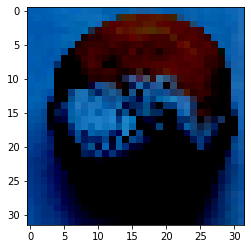

In [13]:
img_t, _ = dataset[2]
img = img_t.permute(1,2,0)
plt.imshow(img);

In [14]:
batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

3061


In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(16,8,kernel_size=3,padding=1)
        self.fc1 = nn.Linear(8*8*8,32)
        self.fc2 = nn.Linear(32,2)
    def forward(self,x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        out = out.view(-1,8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [19]:
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [20]:
device = (torch.device('cuda') if torch.cuda.is_available()
  else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cpu.
